# import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow import keras as ks
from tensorflow.keras.layers import *
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

**Read data**

In [2]:
train=pd.read_csv("../input/sign-recognition/Train.csv")
test=pd.read_csv("../input/sign-recognition/Test.csv")

# General insights 

In [3]:
train.shape, test.shape

((5000, 4098), (5000, 4097))

In [4]:
train.isna().sum()

ID        0
c00000    0
c00001    0
c00002    0
c00003    0
         ..
c04092    0
c04093    0
c04094    0
c04095    0
Target    0
Length: 4098, dtype: int64

# Drop ID column and define train_y , train_x , test_x

In [5]:
train_y=train['Target'].astype('float32')
train_x=train.drop(['Target','ID'],axis=1).astype('int32')
test_x=test.drop(['ID'],axis=1).astype('int32')
train_x.shape,train_y.shape,test_x.shape

((5000, 4096), (5000,), (5000, 4096))

# One Hot Encoding for train_y

In [6]:
train_y=tf.keras.utils.to_categorical(train_y,10)
train_y.shape

(5000, 10)

In [7]:
train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Reshape the size of  images and normalize them  

In [8]:
train_x=train_x.values.reshape(-1,64,64,1)
train_x=train_x/255.0
test_x=test_x.values.reshape(-1,64,64,1)
test_x/255.0
test_x.shape,train_x.shape

((5000, 64, 64, 1), (5000, 64, 64, 1))

# plotting some exemple

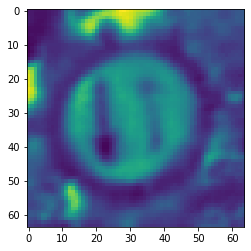

In [9]:
g =plt.imshow(train_x[150][:,:,0]) 

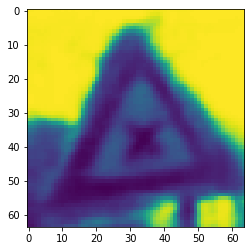

In [10]:
b = plt.imshow(test_x[500][:,:])

In [11]:
x_train , x_test, y_train , y_test=train_test_split(train_x, train_y , test_size=0.15)

In [12]:
x_train.shape , y_train.shape,x_test.shape , y_test.shape

((4250, 64, 64, 1), (4250, 10), (750, 64, 64, 1), (750, 10))

# Generating new images 

In [13]:
datagenerator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [14]:
train_generator = datagenerator.flow(x_train,y_train,)

In [15]:
validation_generator = datagenerator.flow(x_test, y_test)

# Visualizing some exemple of generating images

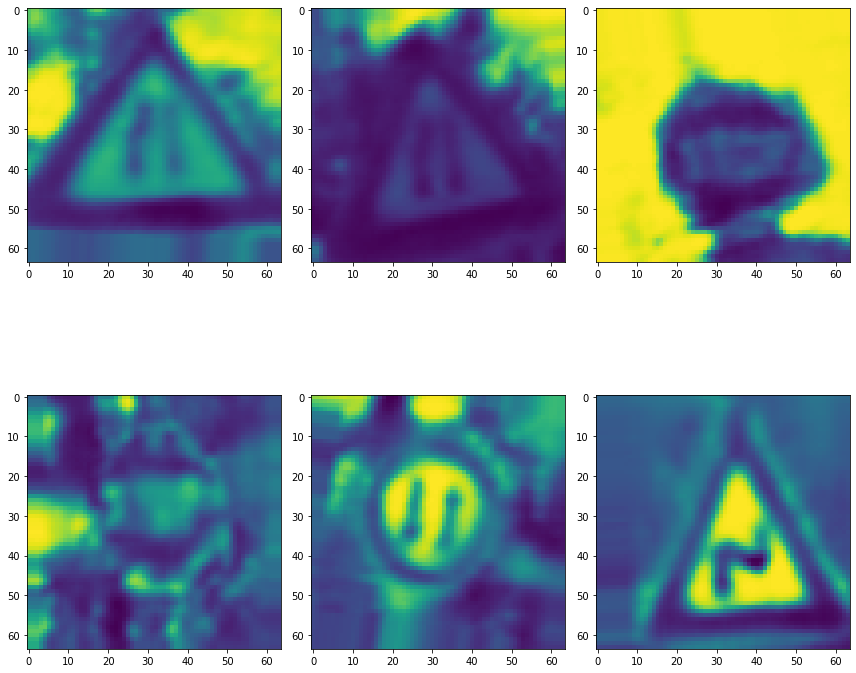

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

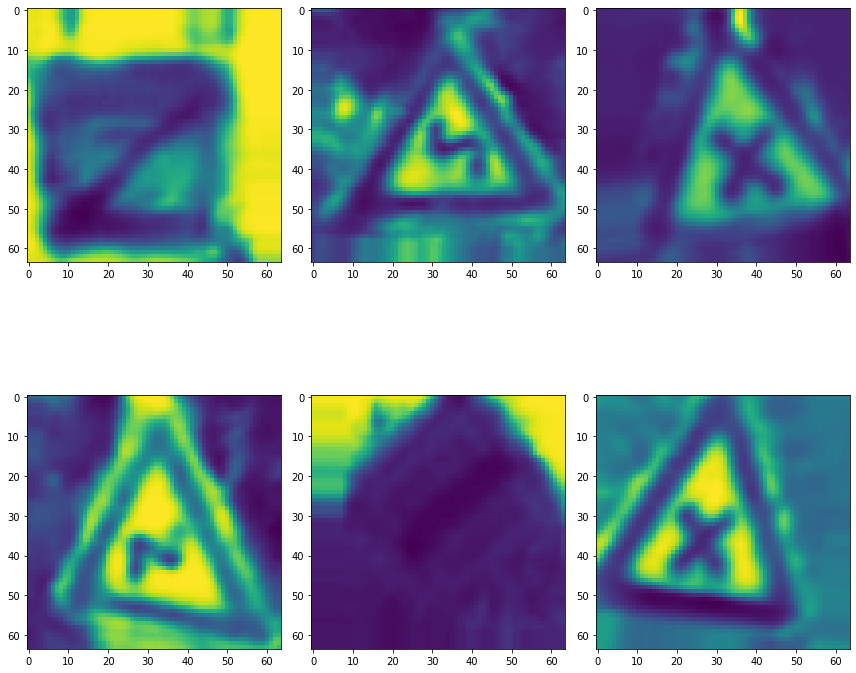

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Modeling

In [18]:
train.head()

,ID,c00000,c00001,c00002,c00003,c00004,c00005,c00006,c00007,c00008,...,c04087,c04088,c04089,c04090,c04091,c04092,c04093,c04094,c04095,Target
0,0,36,36,33,33,31,32,35,37,38,...,52,50,74,117,133,118,102,89,80,8
1,1,142,129,122,138,143,148,152,149,147,...,96,98,97,95,94,89,78,72,69,3
2,2,237,240,242,243,244,245,244,242,241,...,34,33,33,35,36,34,34,33,32,2
3,3,167,149,116,99,75,58,57,55,55,...,67,68,64,56,46,37,35,37,40,6
4,4,254,254,254,254,254,254,254,254,254,...,57,77,128,180,225,242,250,253,254,8


In [19]:
from sklearn.model_selection import train_test_split

train["Target"] = train["Target"].astype('str')

df_train = train
df_test = test

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)


(4000, 4098)
(1000, 4098)
(5000, 4097)


In [20]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
img_size = (64, 64)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagene = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    preprocessing_function=preprocess_input
)
val_datagene = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagene = ImageDataGenerator(preprocessing_function=preprocess_input)

In [22]:
train_generator = train_datagene.flow(
    x_train , y_train
)
validation_generator = datagenerator.flow(x_test, y_test)

In [23]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [24]:
mobileNetModel = MobileNet(weights='imagenet', include_top=False, input_shape = (64, 64, 3))

model = Sequential()
model.add(mobileNetModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))
model.summary()

2022-07-03 19:59:45.150334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 19:59:45.239429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 19:59:45.240157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 19:59:45.241440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 3,239,114
Trainable params: 3,217,226
Non-trainable params: 21,888
_________________________________________________________________


In [25]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [26]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [27]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_mobilenet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [ckpt]

CPU times: user 0 ns, sys: 959 µs, total: 959 µs
Wall time: 714 µs


In [28]:
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch = get_steps(nb_train_samples, batch_size),
#     epochs=epochs,
#     validation_data = train_generator,
#     validation_steps = get_steps(nb_validation_samples, batch_size),
#     callbacks = callbackList
# )